In [1]:
%matplotlib inline
import torch
import torch.utils.data
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import pandas as pd
import seaborn as sns
from pyPDMP.systems import System, LinearSystem, LinearStochasticSystem
from pyPDMP.models import MLP
from pyPDMP.utils import buildDataset

from pyPDMP.models import VAE
from pyPDMP.utils import loss_function

In [2]:
m = LinearStochasticSystem(k=2, b=2, lambd=0.9, mu_jump=0.5, std_jump=0.2, std_s=0.03)
x0 = 2*torch.rand(2)

sol = m.trajectory(x0, 10, 5000)

In [3]:
a = [torch.stack((el.view(1,2), torch.zeros(1,2)), ) for el in sol]

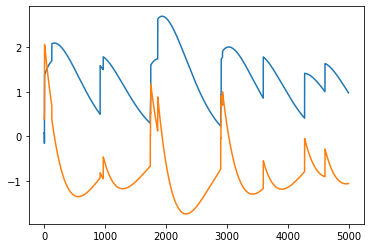

In [4]:
plt.plot(sol.numpy())

In [5]:
m.jcount

17

In [6]:
[m.log[i+1][0] - m.log[i][0] for i in range(len(m.log)-1)]

[1, 2, 119, 794, 51, 773, 3, 4, 115, 1035, 4, 3, 22, 670, 679, 335]

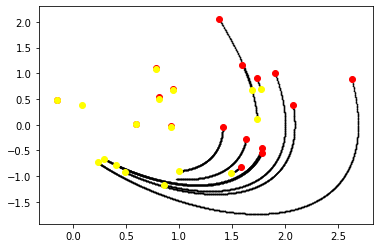

In [7]:
fig = plt.subplot()

plt.scatter([l[0].numpy() for l in sol], [l[1].numpy() for l in sol], s=0.2, color='black')
plt.scatter([l[2][0].numpy() for l in m.log], [l[2][1].numpy() for l in m.log], color='red')
plt.scatter([l[1][0].numpy() for l in m.log], [l[1][1].numpy() for l in m.log], color='yellow')

# Dataset creation

In [8]:
def buildDatasets(system, initial_conds, length, steps):
    dataset = list()
    for x0 in initial_conds:
        sol = system.trajectory(x0, length, steps)
    dataset.append([el[1] for el in system.log])
    return dataset[0]

In [9]:
sys = LinearStochasticSystem(k=2, b=2, lambd=0.9, mu_jump=0.5, std_jump=0.2, std_s=0.03)
initials = [4*torch.rand(2) for i in range(10)]
log = buildDatasets(sys, initials, 5, 200)

In [10]:
log

[tensor([-0.1404, -0.0697]),
 tensor([0.7793, 0.6906]),
 tensor([ 1.4217, -0.5577]),
 tensor([-0.0103, -0.4930]),
 tensor([ 0.2837, -0.4343]),
 tensor([ 1.1826, -0.0994]),
 tensor([0.2593, 1.1475]),
 tensor([0.5598, 0.8725]),
 tensor([ 0.1252, -0.4389]),
 tensor([0.4516, 0.3597]),
 tensor([1.2803, 0.2648]),
 tensor([ 0.0647, -0.6181]),
 tensor([ 0.7450, -0.1873]),
 tensor([ 0.3639, -0.7339]),
 tensor([0.8619, 0.1190]),
 tensor([1.1617, 1.1786]),
 tensor([1.5366, 0.4189]),
 tensor([ 0.0990, -0.5266]),
 tensor([ 0.5007, -0.6109]),
 tensor([0.9797, 0.0740]),
 tensor([ 0.3514, -0.6203]),
 tensor([ 0.0313, -0.5267]),
 tensor([ 0.3485, -0.5301]),
 tensor([ 0.3115, -0.5078]),
 tensor([ 0.1745, -0.6531]),
 tensor([ 0.1996, -0.1201]),
 tensor([0.6860, 0.3187]),
 tensor([1.0528, 1.0682]),
 tensor([ 0.2112, -0.7073]),
 tensor([ 0.0924, -0.2657]),
 tensor([0.1533, 0.2639]),
 tensor([0.5239, 1.0437]),
 tensor([1.1632, 0.8320]),
 tensor([ 0.1791, -0.8524]),
 tensor([ 0.4554, -0.2984]),
 tensor([ 0.9

In [11]:
net = MLP(2, 2)
m = VAE(i=2, out=2)

In [12]:
train = torch.utils.data.TensorDataset(torch.stack(log, 0))

In [13]:
data_loader = torch.utils.data.DataLoader(dataset=train,
                                          batch_size=1, 
                                          shuffle=True)

In [14]:
size = 2

def train(m, loader, epochs):
    for epoch in range(epochs):
        optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)
        m.train()
        train_loss = 0
        for batch_idx, x in enumerate(loader):
            # flatten the batch
            x = x[0][0]
            x = x.view(-1, size)
            optimizer.zero_grad()
            recon_batch, mu, logvar = m(x)
            loss = loss_function(recon_batch, x, mu, logvar, 2)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(x), len(loader.dataset),
                    100. * batch_idx / len(loader),
                    loss.item() / len(x)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(loader.dataset)))

In [16]:
train(m, data_loader, 10)

Train Epoch: 0 [0/42 (0%)]	Loss: -0.828073
====> Epoch: 0 Average loss: 0.5980
Train Epoch: 1 [0/42 (0%)]	Loss: 5.599919
====> Epoch: 1 Average loss: 0.7659
Train Epoch: 2 [0/42 (0%)]	Loss: 4.143992
====> Epoch: 2 Average loss: 0.4962
Train Epoch: 3 [0/42 (0%)]	Loss: 2.584589
====> Epoch: 3 Average loss: 0.4126
Train Epoch: 4 [0/42 (0%)]	Loss: 6.954497
====> Epoch: 4 Average loss: 0.1945
Train Epoch: 5 [0/42 (0%)]	Loss: 2.336439
====> Epoch: 5 Average loss: -0.2400
Train Epoch: 6 [0/42 (0%)]	Loss: 3.570628
====> Epoch: 6 Average loss: -1.1189
Train Epoch: 7 [0/42 (0%)]	Loss: 2.432579
====> Epoch: 7 Average loss: -2.8739
Train Epoch: 8 [0/42 (0%)]	Loss: -1.850929
====> Epoch: 8 Average loss: -3.6764
Train Epoch: 9 [0/42 (0%)]	Loss: 1.004999
====> Epoch: 9 Average loss: -3.9759
